In [5]:

import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm


class simple_NN2(nn.Module):

    def __init__(self):
        # Initialize the superclass
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),  # <--- 2 input variables
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1)  # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out

def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)


def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None,
    t: torch.Tensor = None,
    x_vec: torch.Tensor = None,
    t_vec: torch.Tensor = None,
    v: float = 1.0,
    device: str = None,
) -> torch.float:

    # PDE
    pde_loss = dfdx(model, x, t, order=2) - (1 / v**2) * dfdt(model, x, t, order=2)

    # boundary conditions
    boundary_x0 = torch.ones_like(t_vec, requires_grad=True).to(device) * x[0]
    boundary_loss_x0 = model(boundary_x0, t_vec)  # f(x0, t)
    boundary_x1 = torch.ones_like(t_vec, requires_grad=True).to(device) * x[-1]
    boundary_loss_x1 = model(boundary_x1, t_vec)  # f(x1, t)

    # initial conditions
    n = 1
    f_initial = 0.5 * torch.sin(n * np.pi * x_vec).reshape(
        -1, 1)  # 0.5*sin(2*pi*x)
    t_initial = torch.zeros_like(x_vec)  # t0
    t_initial.requires_grad = True
    initial_loss_f = model(x_vec, t_initial) - f_initial  # L_initF
    initial_loss_df = dfdt(model, x_vec, t_initial, order=1)  # L_initDF

    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        initial_loss_f.pow(2).mean() + \
        initial_loss_df.pow(2).mean()

    return final_loss

epoch: 0, loss: 0.164216
epoch: 300, loss: 0.045187
epoch: 600, loss: 0.040180
epoch: 900, loss: 0.033273
epoch: 1200, loss: 0.026741
epoch: 1500, loss: 0.017246
epoch: 1800, loss: 0.011814
epoch: 2100, loss: 0.010963
epoch: 2400, loss: 0.006366
epoch: 2700, loss: 0.004468


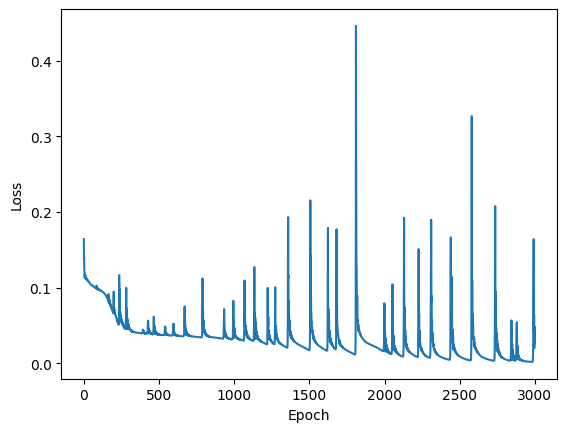

In [6]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

loss_values = []

# define the domain
x_min, x_max = 0.0, 1
t_min, t_max = 0.0, 1.25

# generate the time-space meshgrid
x_vec = torch.linspace(x_min, x_max, steps=100, requires_grad=True)
t_vec = torch.linspace(t_min, t_max, steps=150, requires_grad=True)
grids = torch.meshgrid(x_vec, t_vec, indexing="ij")
# flatten the vectors and move to device
x_vec = x_vec.reshape(-1, 1).to(device)
t_vec = t_vec.reshape(-1, 1).to(device)
# flatten the meshgrid and move to device
x = grids[0].flatten().reshape(-1, 1).to(device)
t = grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)
# initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(3000):

    loss = compute_loss(model,
                        x=x,
                        t=t,
                        x_vec=x_vec,
                        t_vec=t_vec,
                        device=device)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

        # Prediction
        y_np = model(x, t).reshape([100, -1]).to("cpu").detach().numpy()
        fig, ax = plt.subplots()
        ax.imshow(y_np, extent=[t_min, t_max, x_min, x_max], cmap = cm.coolwarm, vmin=-.5, vmax=.5)
        ax.set_xlabel("t")
        ax.set_ylabel("x")
        fig.savefig(f"___figs/pinn_u_{ep}.png", dpi=250)
        plt.close(fig)

    loss_values.append(loss.item())

# Plot the loss
fig, ax = plt.subplots()
ax.plot(loss_values)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()

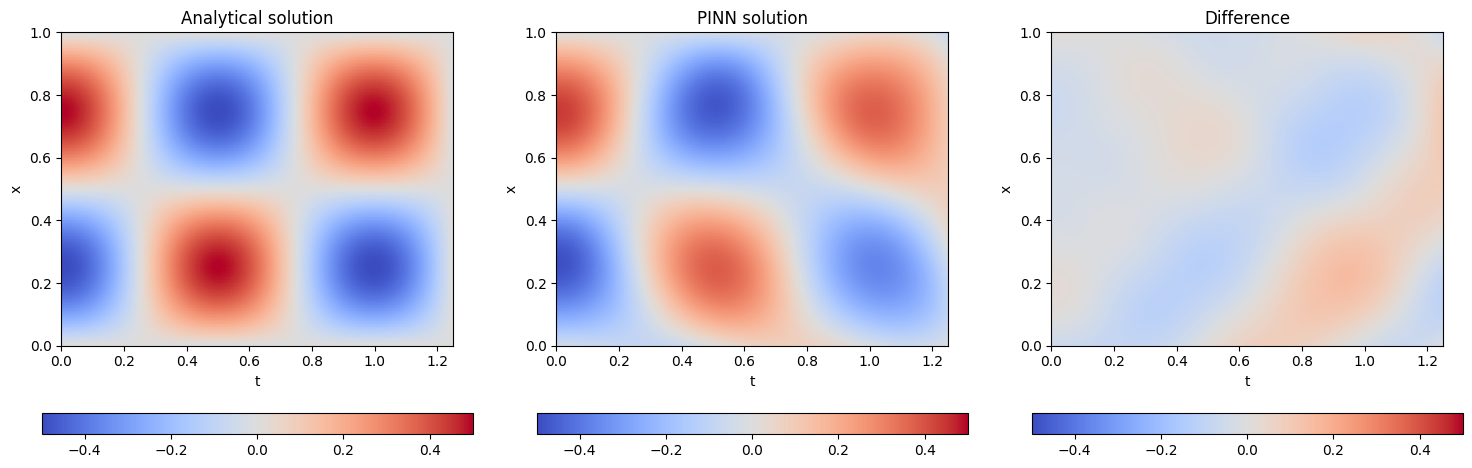

In [8]:
def analytical_solution(x: np.ndarray,
                        t: np.ndarray,
                        n: float = 1.0,
                        A: float = 1.0,
                        v: float = 1.0,
                        L: float = 1.0):
    """Analytical solution for the standing wave"""
    return A * np.cos((n * np.pi * v / L) * t) * np.sin((n* np.pi / L) * x)


u_nn = model(x, t).reshape([100, -1]).to("cpu").detach().numpy()

x_mat, t_mat = np.meshgrid(x_vec.detach().numpy().flatten(),
                           t_vec.detach().numpy().flatten(),
                           indexing="ij")
u_analytic = analytical_solution(x_mat, t_mat, A=0.5, n=1)

fig, axs = plt.subplots(1,3, figsize=(15, 5))

vmax = np.max([np.abs(u_nn), np.abs(u_analytic)])
img1 = axs[0].imshow(u_analytic , extent=[t_min, t_max, x_min, x_max], cmap = cm.coolwarm, vmin=-vmax, vmax=vmax)
img2 = axs[1].imshow(u_nn, extent=[t_min, t_max, x_min, x_max], cmap = cm.coolwarm, vmin=-vmax, vmax=vmax)
img3 = axs[2].imshow(u_nn - u_analytic, extent=[t_min, t_max, x_min, x_max], cmap = cm.coolwarm, vmin=-vmax, vmax=vmax)

fig.colorbar(img1, ax=axs[0], location="bottom")
fig.colorbar(img2, ax=axs[1], location="bottom")
fig.colorbar(img3, ax=axs[2], location="bottom")

axs[0].set_title("Analytical solution")
axs[1].set_title("PINN solution")
axs[2].set_title("Difference")

for ax in axs:
    ax.set_xlabel("t")
    ax.set_ylabel("x")

plt.tight_layout()
plt.show()